# BTC Predictor

In [72]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

## Stock Predictor Lib


In [73]:
def PredtoClass(a):
    pred_class = []
    for i in range(len(a)):
        if a[i]<.3:
            pred_class.append(0)
        else:
            pred_class.append(1)
    return pred_class

def accuracy_rf(preds, y_val):
    return  sum(1- abs(PredtoClass(preds) - y_val))/len(y_val)

In [74]:
import json as js
import numpy as np
import pandas as pd
from ta import *
try:
    from fastai.imports import *
    from fastai.structured import *
    from fastai.column_data import *
except ImportError:
    print('*** Failed importing fast.ai modules ***')

try:
    from sklearn.metrics import classification_report
    from sklearn.metrics import confusion_matrix
except ImportError:
    print('*** Failed importing sklearn ***')

class StockPredictor:

    def __init__(self, df, index):
        self.df = df
        self.index = index

    # ///////////////////////////////
    # /////// DATA CLEANING /////////
    # ///////////////////////////////

    def sample_train(self, sampleSize):
        self.train = self.df.iloc[-sampleSize:].copy()
        print('Train size: ' + str(len(self.train)) +
              ' Original size: ' + str(len(self.df)))

    def set_date_as_index(self):
        self.train.loc[:, self.index] = pd.to_datetime(
            self.train[self.index]).copy()

    def set_date_as_index_unix(self):
        self.train.loc[:, self.index] = pd.to_datetime(
            self.train[self.index], unit='s').copy()

    def split_test_train(self, percent_split):
        train_records_count = int(len(self.train) * percent_split)
        test_records_count = int(len(self.train) * (1-percent_split))
        self.test = self.train.tail(test_records_count)
        self.train = self.train.head(train_records_count)
        self.test = self.test.set_index('Timestamp')
        self.train = self.train.set_index('Timestamp')
        print('Train size: ' + str(len(self.train)) +
              ' Test size: ' + str(len(self.test)))

    def normalize_train(self, volume, open, high, low, close, weighted_price):
        self.train = pd.DataFrame({
            'Timestamp': self.train[self.index],
            'Volume': self.train[volume],
            'Open': self.train[open],
            'High': self.train[high],
            'Low': self.train[low],
            'Close': self.train[close],
            'Weighted_Price': self.train[weighted_price]
        })[['Timestamp', 'Volume', 'Open', 'High', 'Low', 'Close', 'Weighted_Price']]

    def clean_train(self):
        self.train = self.train.replace([np.inf, -np.inf], np.nan)
        self.train.fillna(method='ffill', inplace=True)
        self.train.fillna(method='bfill', inplace=True)
        print('Train size: ' + str(len(self.train)))

    """ Trim the beginning to have accurate TA values, trim the end to have accurate target value"""

    def trim_ends(self, begin_count, end_count):
        self.train = self.train.iloc[begin_count:]
        self.train = self.train.iloc[:-end_count]
        print('Trim beginning: ' + str(begin_count) + '. Trim end: ' +
              str(end_count) + '. Train size: ' + str(len(self.train)))

    # ///////////////////////////////
    # ////// FEATURE CREATION ///////
    # ///////////////////////////////

    def get_train_size(self, percent_split):
        train_records_count = int(len(self.train) * percent_split)
        print('Train size: ' + str(train_records_count) +
              ' percent_split: ' + str(percent_split))
        return train_records_count

    def get_validation_indexes(self, train_size, df):
        validation_indexes = list(range(train_size, len(df)))
        print('Validation Index size: ' + str(len(validation_indexes)))
        return validation_indexes

    def apply_variable_types(self, df, cat_vars, contin_vars, dep):
        dep_array = [] if dep is None else [dep]
        df = df[cat_vars + contin_vars + dep_array].copy()
        for v in cat_vars:
            df[v] = df[v].astype('category').cat.as_ordered()
        for v in contin_vars:
            df[v] = df[v].astype('float32')
        return df

    # ///////////////////////////////
    # //// FEATURE ENGINEERING //////
    # ///////////////////////////////

    def get_max_lookback(self, target, lookback):
        return self.train[target].rolling(window=lookback, min_periods=1).max()

    def get_min_lookback(self, target, lookback):
        return self.train[target].rolling(window=lookback, min_periods=1).min()

    def get_moving_average(self, target, lookback):
        return self.train[target].rolling(window=lookback, min_periods=1).mean()

    def get_max_lookahead(self, df, target, lookahead):
        return df[target] \
            .iloc[::-1] \
            .rolling(window=lookahead, min_periods=1) \
            .max() \
            .iloc[::-1]

    def get_last_lookahead(self, df, target, lookahead):
        return df[target].shift(-lookahead)

    def get_lookback(self, df, target, lookback):
        return df[target].shift(lookback)

    def add_historical_candles(self, df, lookback):
        for i in range(1, lookback):
            df[str(i) + 'Open'] = self.get_lookback(df,
                                                    'Open', i).astype('float')
            df[str(i) + 'High'] = self.get_lookback(df,
                                                    'High', i).astype('float')
            df[str(i) + 'Low'] = self.get_lookback(df,
                                                   'Low', i).astype('float')
            df[str(i) + 'Close'] = self.get_lookback(df,
                                                     'Close', i).astype('float')
            df[str(i) + 'Volume'] = self.get_lookback(df,
                                                      'Volume', i).astype('float')

    def add_ta(self):
        self.train = add_all_ta_features(
            self.train, "Open", "High", "Low", "Close", "Volume", fillna=True)
        self.train['sma5'] = self.get_moving_average("Close", 5)
        self.train['sma15'] = self.get_moving_average("Close", 15)
        self.train['sma30'] = self.get_moving_average("Close", 30)
        self.train['sma60'] = self.get_moving_average("Close", 60)
        self.train['sma90'] = self.get_moving_average("Close", 90)
        self.add_historical_candles(self.train, 30)
        # rsi = self.train['momentum_rsi']
        # self.train['rsi_category'] = rsi < 30

    """ Set the target (dependent variable) by looking ahead in a certain time window and percent increase
        to determine if the action should be a BUY or a SELL. BUY is true/1 SELL is false/0"""

    def set_target(self, target, lookahead, percentIncrease):
        max_lookahead = self.get_max_lookahead(self.train, target, lookahead)
        self.train['action'] = max_lookahead > (
            percentIncrease * self.train['Close'])
#        self.train['max'] =max_in_lookahead_timeframe
        self.train.action = self.train.action.astype(int)
        buy_count = str(len(self.train[self.train.action == 1]))
        sell_count = str(len(self.train[self.train.action == 0]))
        print('Buy count: ' + buy_count + ' Sell count: ' + sell_count)

    def set_target_hold(self, target, lookahead, percentIncrease, percentDecrease):
        self.train['action'] = 0
        max_lookahead = self.get_max_lookahead(self.train, target, lookahead)
        self.train.loc[max_lookahead > percentDecrease *
                       self.train['Close'], 'action'] = 1
        self.train.loc[max_lookahead > percentIncrease *
                       self.train['Close'], 'action'] = 2
        self.train.action = self.train.action.astype(int)
        sell_count = str(len(self.train[self.train.action == 0]))
        hold_count = str(len(self.train[self.train.action == 1]))
        buy_count = str(len(self.train[self.train.action == 2]))
        print('Buy count: ' + buy_count + ' Sell count: ' +
              sell_count + ' Hold count: ' + hold_count)

    def set_target_hold_reg(self, target, lookahead, percentIncrease):
        self.train['max_lookahead'] = 0
        max_lookahead = self.get_max_lookahead(self.train, target, lookahead)
        self.train['max_lookahead'] = max_lookahead
        self.train.max_lookahead = self.train.max_lookahead.astype(np.float32)

    def add_date_values(self):
        add_datepart(self.train, 'Timestamp', drop=False)
        self.train['hour'] = self.train['Timestamp'].dt.hour
        self.train['minute'] = self.train['Timestamp'].dt.minute

    def set_target_historical(self, target, lookback, percentIncrease):
        max_in_lookback_timeframe = self.get_max_lookback(target, lookback)
        self.train['action'] = max_in_lookback_timeframe > (
            percentIncrease * self.train['Close'])
        self.train.action = self.train.action.astype(int)
        buy_count = str(len(self.train[self.train.action == 1]))
        sell_count = str(len(self.train[self.train.action == 0]))
        print('Buy count: ' + buy_count + ' Sell count: ' + sell_count)

    def set_target_historical_hold(self, target, lookback, percentIncrease):
        self.train['action'] = 0
        max_lookback = self.get_max_lookback(target, lookback)
        self.train.loc[max_lookback > self.train['Close'], 'action'] = 1

        self.train.loc[max_lookback > percentIncrease *
                       self.train['Close'], 'action'] = 2

        self.train.action = self.train.action.astype(int)
        sell_count = str(len(self.train[self.train.action == 0]))
        hold_count = str(len(self.train[self.train.action == 1]))
        buy_count = str(len(self.train[self.train.action == 2]))
        print('Buy count: ' + buy_count + ' Sell count: ' +
              sell_count + ' Hold count: ' + hold_count)

    # ///////////////////////////////
    # ///////// EVALUATION //////////
    # ///////////////////////////////

    def generate_net_profit_result(self, df, startAmount, totalBuys, totalSells):
        startClose = df.Close.iloc[0]
        endClose = df.Close.iloc[-1]
        endBuyAmount = df.buyAmount.iloc[-1]
        endSellAmount = df.sellAmount.iloc[-1]
        endAmount = endBuyAmount if (
            endBuyAmount > 0) else (endSellAmount * endClose)
        buyAndHoldPercentIncrease = ((endClose - startClose)/startClose) * 100
        percentIncrease = ((endAmount - startAmount)/startAmount) * 100
        percentDifference = percentIncrease - buyAndHoldPercentIncrease

        result = {
            'startClose': startClose,
            'endClose': endClose,
            'startAmount': startAmount,
            'endAmount': endAmount,
            'buyAndHoldPercentIncrease': round(buyAndHoldPercentIncrease, 3),
            'percentIncrease': round(percentIncrease, 3),
            'percentDifference': round(percentDifference, 3),
            'totalTrades': totalBuys + totalSells
        }
        return result

    def calculate_accuracy_hold(self, df):
        successful_predictions = df.loc[df.action == df.predicted]
        total_accuracy = len(successful_predictions)/len(df)
        total_sell_actions = df.loc[df.action == 0]
        total_hold_actions = df.loc[df.action == 1]
        total_buy_actions = df.loc[df.action == 2]
        successful_sell_predictions = successful_predictions.loc[successful_predictions.action == 0]
        successful_hold_predictions = successful_predictions.loc[successful_predictions.action == 1]
        successful_buy_predictions = successful_predictions.loc[successful_predictions.action == 2]
        sell_accuracy = len(successful_sell_predictions) / \
            len(total_sell_actions)
        hold_accuracy = len(successful_hold_predictions) / \
            len(total_hold_actions)
        buy_accuracy = len(successful_buy_predictions)/len(total_buy_actions)
        f1Score = (buy_accuracy + sell_accuracy + hold_accuracy)/3
        result = {
            'F1Score': round(f1Score, 3),
            'totalAccuracy': round(total_accuracy, 3),
            'buyAccuracy': round(buy_accuracy, 3),
            'sellAccuracy': round(sell_accuracy, 3),
            'hold_accuracy': round(hold_accuracy, 3),
            'totalSellActions': len(total_sell_actions),
            'totalHoldActions': len(total_hold_actions),
            'totalBuyActions': len(total_buy_actions),
            'successfulBuyPredictions': len(successful_buy_predictions)
        }
        return result

    def calculate_accuracy(self, df):
        successful_predictions = df.loc[df.action == df.predicted]
        total_accuracy = len(successful_predictions)/len(df)
        total_buy_actions = df.loc[df.action == 1]
        total_sell_actions = df.loc[df.action == 0]
        successful_buy_predictions = successful_predictions.loc[successful_predictions.action == 1]
        successful_sell_predictions = successful_predictions.loc[successful_predictions.action == 0]
        buy_accuracy = len(successful_buy_predictions)/len(total_buy_actions)
        sell_accuracy = (len(successful_sell_predictions) /
                         len(total_sell_actions))
        f1Score = (buy_accuracy + sell_accuracy)/2
        result = {
            'F1Score': round(f1Score, 3),
            'totalAccuracy': round(total_accuracy, 3),
            'buyAccuracy': round(buy_accuracy, 3),
            'sellAccuracy': round(sell_accuracy, 3),
            'totalBuyActions': len(total_buy_actions),
            'successfulBuyPredictions': len(successful_buy_predictions)
        }
        return result

    def calculate_net_profit(self, inputDf, startAmount, fee):
        df = inputDf
        df['buyAmount'] = 0
        df['sellAmount'] = 0
        totalBuys = 0
        totalSells = 0
        for index, row in df.iterrows():
            prevBuyAmount = df.buyAmount.get(index - 1, np.nan)
            prevSellAmount = df.sellAmount.get(index - 1, np.nan)
            predicted = row.predicted
            if index == df.index[0]:
                df.loc[index, 'buyAmount'] = startAmount
            elif predicted == 1 and prevBuyAmount > 0:
                # BUY
                base_sell = prevBuyAmount/row.Close
                df.loc[index, 'sellAmount'] = base_sell - (base_sell * fee)
                totalBuys += 1
            elif predicted == 1 and prevBuyAmount == 0:
                df.loc[index, 'sellAmount'] = prevSellAmount
            elif predicted == 0 and prevSellAmount > 0:
                # SELL
                base_buy = prevSellAmount*row.Close
                df.loc[index, 'buyAmount'] = base_buy - (base_buy*fee)
                totalSells += 1
            elif predicted == 0 and prevSellAmount == 0:
                df.loc[index, 'buyAmount'] = prevBuyAmount
            else:
                raise ValueError(
                    'This is weird, invalid predicted value: ' + str(predicted) + ' prevSellAmount: ' +
                    str(prevSellAmount) + ' prevBuyAmount: ' + str(prevBuyAmount))
        result = self.generate_net_profit_result(
            df, startAmount, totalBuys, totalSells)
        self.net_profit_df = df
        self.result = result
        # print(js.dumps(result, sort_keys=False, indent=4, separators=(',', ': ')))

    def calculate_net_profit_hold(self, inputDf, startAmount, fee):
        df = inputDf
        df['buyAmount'] = 0
        df['sellAmount'] = 0
        totalBuys = 0
        totalSells = 0
        for index, row in df.iterrows():
            prevBuyAmount = df.buyAmount.get(index - 1, np.nan)
            prevSellAmount = df.sellAmount.get(index - 1, np.nan)
            predicted = row.predicted
            if index == df.index[0]:
                df.loc[index, 'buyAmount'] = startAmount
            elif predicted == 2 and prevBuyAmount > 0:
                # BUY
                base_sell = prevBuyAmount / row.Close
                df.loc[index, 'sellAmount'] = base_sell - (base_sell * fee)
                totalBuys += 1
            elif predicted == 2 and prevBuyAmount == 0:
                df.loc[index, 'sellAmount'] = prevSellAmount
            elif predicted == 0 and prevSellAmount > 0:
                # SELL
                base_buy = prevSellAmount * row.Close
                df.loc[index, 'buyAmount'] = base_buy - (base_buy*fee)
                totalSells += 1
            elif predicted == 0 and prevSellAmount == 0:
                df.loc[index, 'buyAmount'] = prevBuyAmount
            elif predicted == 1:
                # HOLD
                df.loc[index, 'buyAmount'] = prevBuyAmount
                df.loc[index, 'sellAmount'] = prevSellAmount
            else:
                raise ValueError(
                    'This is weird, invalid predicted value: ' + str(predicted))

        result = self.generate_net_profit_result(
            df, startAmount, totalBuys, totalSells)
        self.net_profit_df = df
        self.result = result
        # print(js.dumps(result, sort_keys=False, indent=4, separators=(',', ': ')))

    def calculate_net_profit_hold_reg(self, inputDf, startAmount, fee, percentIncrease):
        df = inputDf
        df['buyAmount'] = 0
        df['sellAmount'] = 0
        totalBuys = 0
        totalSells = 0
        for index, row in df.iterrows():
            prevBuyAmount = df.buyAmount.get(index - 1, np.nan)
            prevSellAmount = df.sellAmount.get(index - 1, np.nan)
            predicted = row.predicted
            threshold = percentIncrease * row.Close
            if index == df.index[0]:
                df.loc[index, 'buyAmount'] = startAmount
            elif predicted >= threshold and prevBuyAmount > 0:
                # BUY
                base_sell = prevBuyAmount / row.Close
                df.loc[index, 'sellAmount'] = base_sell - (base_sell * fee)
                totalBuys += 1
            elif predicted >= threshold and prevBuyAmount == 0:
                df.loc[index, 'sellAmount'] = prevSellAmount
            elif predicted >= row.Close:
                # HOLD
                df.loc[index, 'buyAmount'] = prevBuyAmount
                df.loc[index, 'sellAmount'] = prevSellAmount
            elif predicted < row.Close and prevSellAmount > 0:
                # SELL
                base_buy = prevSellAmount * row.Close
                df.loc[index, 'buyAmount'] = base_buy - (base_buy*fee)
                totalSells += 1
            elif predicted < row.Close and prevSellAmount == 0:
                df.loc[index, 'buyAmount'] = prevBuyAmount
            else:
                raise ValueError(
                    'This is weird, invalid predicted value: ' + str(predicted) + ' Close: ' + str(row.Close))

        result = self.generate_net_profit_result(
            df, startAmount, totalBuys, totalSells)
        self.net_profit_df = df
        self.result = result

    def confusion_matrix(self, actual, predicted, target_names, target):
        print(classification_report(actual, predicted, target_names=target_names))
        cm = confusion_matrix(actual, predicted)
        plot_confusion_matrix(cm, target)

    # ///////////////////////////////
    # /////////// UTIL //////////////
    # ///////////////////////////////

    def save_to_feather(self, path):
        self.train.reset_index(inplace=True)
        self.train.to_feather(f'{path}historical_parsed')

    def read_from_feather(self, path):
        self.train = pd.read_feather(f'{path}historical_parsed')
        self.set_date_as_index()

    """ usage conflateTimeFrame(df, '5T') """

    def conflate_time_frame(self, df, timeFrame):
        ohlc_dict = {
            'Open': 'first',
            'High': 'max',
            'Low': 'min',
            'Close': 'last',
            'Volume': 'sum'
        }
        return df.resample(timeFrame).agg(ohlc_dict)

    def plot_profit(self, df):
        df.reset_index(inplace=True)
        df.plot(
            x='Timestamp',
            y=['Close', 'buyAmount'],
            style='o',
            figsize=(10, 5),
            grid=True)


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

## Config


In [75]:
from fastai.structured import *
from fastai.column_data import *
np.set_printoptions(threshold=50, edgeitems=20)
from ta import *
from IPython.display import HTML
from IPython.core.display import display

In [76]:
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

index='Timestamp'
# index='time_period_start'
lookahead = 15
percentIncrease = 1.002
recordsCount = 80000
test_ratio  = 0.95
train_ratio = 0.95
lr = 1e-3
dropout = 0.04
modelName = 'btcBinaryClassificationModel'
dep = 'action'
PATH='data/stock/'

In [77]:
cat_vars = ['TimestampYear', 'TimestampMonth', 'TimestampWeek', 'TimestampDay', 'hour','minute', 'TimestampDayofweek',
'TimestampDayofyear','TimestampIs_month_end', 'TimestampIs_month_start', 'TimestampIs_quarter_end',
'TimestampIs_quarter_start','TimestampIs_year_end', 'TimestampIs_year_start']

contin_vars = ['Open', 'Close','High', 'Low', 'Volume', 'TimestampElapsed',
'volume_adi','volume_obv','volume_obvm','volume_cmf','volume_fi','volume_em','volume_vpt','volume_nvi',
'volatility_atr','volatility_bbh','volatility_bbl','volatility_bbm','volatility_bbhi','volatility_bbli',
'volatility_kcc','volatility_kch','volatility_kcl','volatility_kchi','volatility_kcli','volatility_dch',
'volatility_dcl','volatility_dchi','volatility_dcli','trend_macd','trend_macd_signal','trend_macd_diff',
'trend_ema_fast','trend_ema_slow','trend_adx','trend_vortex_ind_pos',
'trend_vortex_ind_neg','trend_vortex_diff','trend_trix','trend_mass_index','trend_cci','trend_dpo','trend_kst',
'trend_kst_sig','trend_kst_diff','trend_ichimoku_a','trend_ichimoku_b'
,'trend_aroon_up','trend_aroon_down','trend_aroon_ind','momentum_rsi','momentum_mfi','momentum_tsi'
,'momentum_uo','momentum_stoch','momentum_stoch_signal','momentum_wr','momentum_ao','others_dr','others_dlr','others_cr'
,'sma5','sma15','sma30','sma60','sma90'
,'1Open','1High','1Low','1Close','1Volume','2Open','2High','2Low','2Close','2Volume'
,'3Open','3High','3Low','3Close','3Volume','4Open','4High','4Low','4Close','4Volume'
,'5Open','5High','5Low','5Close','5Volume','6Open','6High','6Low','6Close','6Volume'
,'7Open','7High','7Low','7Close','7Volume','8Open','8High','8Low','8Close','8Volume','9Open','9High','9Low'
,'9Close','9Volume','10Open','10High','10Low','10Close','10Volume','11Open','11High','11Low','11Close','11Volume'
,'12Open','12High','12Low','12Close','12Volume','13Open','13High','13Low','13Close','13Volume'
,'14Open','14High','14Low','14Close','14Volume','15Open','15High','15Low','15Close','15Volume'
,'16Open','16High','16Low','16Close','16Volume','17Open','17High','17Low','17Close','17Volume'
,'18Open','18High','18Low','18Close','18Volume','19Open','19High','19Low','19Close','19Volume'
,'20Open','20High','20Low','20Close','20Volume','21Open','21High','21Low','21Close','21Volume'
,'22Open','22High','22Low','22Close','22Volume','23Open','23High','23Low','23Close','23Volume'
,'24Open','24High','24Low','24Close','24Volume','25Open','25High','25Low','25Close','25Volume'
,'26Open','26High','26Low','26Close','26Volume','27Open','27High','27Low','27Close','27Volume'              
]

len(cat_vars),len(contin_vars)

(14, 201)

## Create datasets

In [78]:
table_names = [
    'coinbaseUSD_1-min_data_2014-12-01_to_2018-06-27',
#     'coinbaseUSD_1-min_data_2014-12-01_to_2018-11-11',
#     'bitstampUSD_1-min_data_2012-01-01_to_2018-06-27',
#     'btc-bitstamp-2012-01-01_to_2018-01-08'
#         'BTC_COINBASE_2018-07-25_09-06'
#         'ETH_COINBASE_07-21_08-24'
]

In [79]:
tables = [pd.read_csv(f'{PATH}{fname}.csv', low_memory=False) for fname in table_names]

In [80]:
for t in tables: display(t.head())

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,1417411980,300.0,300.0,300.0,300.0,0.01,3.0,300.0
1,1417412040,300.0,300.0,300.0,300.0,0.01,3.0,300.0
2,1417412100,300.0,300.0,300.0,300.0,0.01,3.0,300.0
3,1417412160,300.0,300.0,300.0,300.0,0.01,3.0,300.0
4,1417412220,300.0,300.0,300.0,300.0,0.01,3.0,300.0


In [81]:
train= tables[0]

In [82]:
# train = train.head(1700000)
p = StockPredictor(train, index)
p.sample_train(recordsCount)

Train size: 80000 Original size: 1819074


## Data Cleaning

In [83]:
p.set_date_as_index_unix()
p.normalize_train('Volume_(BTC)','Open','High','Low','Close', 'Weighted_Price')
# p.set_date_as_index()
# p.normalize_train('volume_traded','price_open','price_high','price_low','price_close', 'price_close')
p.train.head()

,Timestamp,Volume,Open,High,Low,Close,Weighted_Price
1739074,2018-05-02 10:41:00,1.446230,9157.83,9157.90,9156.77,9157.90,9157.118949
1739075,2018-05-02 10:42:00,1.099806,9157.90,9161.45,9154.82,9154.82,9156.446488
1739076,2018-05-02 10:43:00,1.741160,9155.05,9155.06,9155.05,9155.05,9155.051601
1739077,2018-05-02 10:44:00,0.342800,9155.06,9155.06,9155.05,9155.05,9155.050408
1739078,2018-05-02 10:45:00,1.105798,9155.05,9155.05,9150.58,9150.59,9151.002492


## Join Bitstamp

In [84]:
# bitstamp= tables[1].tail(recordsCount)
# bitstamp[index] = pd.to_datetime(bitstamp[index], unit='s')
# bitstampExtract = pd.DataFrame({
#     'BitstampTimestamp':bitstamp.Timestamp,
#     'BitstampClose':bitstamp.Close,
# })[[ 'BitstampTimestamp','BitstampClose']] 
# bitstampExtract = bitstampExtract.reset_index(drop=True)
# p.train = pd.concat([bitstampExtract, p.train], axis=1)

In [85]:
# valpred = valpred.reset_index(drop=True)
# train = train.set_index(pd.DatetimeIndex(train[index]))
# p.train = p.conflate_time_frame(p.train, '5T')
# len(train)

## Feature Engineering

In [86]:
# add technical analysis
p.add_ta()
p.clean_train()

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ta/trend.py:170: RuntimeWarning: invalid value encountered in double_scalars
  dip[i] = 100 * (dip_mio[i]/trs[i])
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ta/trend.py:174: RuntimeWarning: invalid value encountered in double_scalars
  din[i] = 100 * (din_mio[i]/trs[i])
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ta/trend.py:503: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  aroon_up = close.rolling(n).apply(lambda x: float(np.argmax(x) + 1) / n * 100)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ta/trend.py:525: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change

Train size: 80000


In [87]:
p.set_target('Close',lookahead, percentIncrease)

Buy count: 18261 Sell count: 61739


In [88]:
p.add_date_values()
p.trim_ends(100,100)

Trim beginning: 100. Trim end: 100. Train size: 79800


In [89]:
# p.train.to_csv(f'{PATH}btc_historical_parsed.csv', sep=',', encoding='utf-8')
# p.save_to_feather(PATH)
# p.read_from_feather(PATH)
p.train

,Timestamp,Volume,Open,High,Low,Close,Weighted_Price,volume_adi,volume_obv,volume_obvm,volume_cmf,volume_fi,volume_em,volume_vpt,volume_nvi,volatility_atr,volatility_bbh,volatility_bbl,volatility_bbm,volatility_bbhi,volatility_bbli,volatility_kcc,volatility_kch,volatility_kcl,volatility_kchi,volatility_kcli,volatility_dch,volatility_dcl,volatility_dchi,volatility_dcli,trend_macd,trend_macd_signal,trend_macd_diff,trend_ema_fast,trend_ema_slow,trend_adx,trend_vortex_ind_pos,trend_vortex_ind_neg,trend_vortex_diff,trend_trix,trend_mass_index,trend_cci,trend_dpo,trend_kst,trend_kst_sig,trend_kst_diff,trend_ichimoku_a,trend_ichimoku_b,trend_aroon_up,trend_aroon_down,...,23High,23Low,23Close,23Volume,24Open,24High,24Low,24Close,24Volume,25Open,25High,25Low,25Close,25Volume,26Open,26High,26Low,26Close,26Volume,27Open,27High,27Low,27Close,27Volume,28Open,28High,28Low,28Close,28Volume,29Open,29High,29Low,29Close,29Volume,action,TimestampYear,TimestampMonth,TimestampWeek,TimestampDay,TimestampDayofweek,TimestampDayofyear,TimestampIs_month_end,TimestampIs_month_start,TimestampIs_quarter_end,TimestampIs_quarter_start,TimestampIs_year_end,TimestampIs_year_start,TimestampElapsed,hour,minute
1739174,2018-05-02 12:21:00,1.025100,9131.01,9131.01,9131.00,9131.00,9131.008250,-2.433300,0.000000,-1.077569,-0.584520,2.717650,-0.856391,-3.916146e-04,999.661202,1.830571,9151.147147,9128.664853,9139.9060,0.0,0.0,9135.495667,9137.485667,9133.505667,0.0,0.0,9147.15,9131.00,0.0,1.0,-3.950507,-3.132197,-0.818310,9135.850250,9139.800757,22.275033,0.432700,1.541172,1.108472,-0.004859,26.012958,-108.818481,4.0940,-1.110826,-0.754815,-0.356011,9150.8825,9157.545,24.0,96.0,...,9145.01,9145.00,9145.01,0.631800,9145.01,9145.01,9145.00,9145.01,1.480567,9145.00,9145.01,9145.00,9145.00,0.613555,9145.00,9145.01,9145.00,9145.01,1.861110,9145.99,9146.00,9145.00,9145.00,3.622265,9146.00,9146.00,9145.99,9145.99,1.454844,9147.00,9147.01,9145.99,9146.00,0.805304,0,2018,5,18,2,2,122,False,False,False,False,False,False,1525263660,12,21
1739175,2018-05-02 12:22:00,0.697924,9131.00,9131.01,9131.00,9131.01,9131.007749,-0.327176,0.697924,-1.066339,-0.587258,-0.007103,-0.856391,7.643455e-07,999.662296,1.700530,9150.467140,9127.730860,9139.0990,0.0,0.0,9134.595667,9136.585667,9132.605667,0.0,0.0,9145.01,9131.00,0.0,0.0,-4.043740,-3.314506,-0.729234,9135.105596,9139.149336,21.958594,0.432700,1.541172,1.108472,-0.005162,26.306742,-96.996386,0.9010,-1.206634,-0.830757,-0.375877,9150.8825,9157.545,20.0,92.0,...,9145.01,9145.00,9145.00,0.442938,9145.01,9145.01,9145.00,9145.01,0.631800,9145.01,9145.01,9145.00,9145.01,1.480567,9145.00,9145.01,9145.00,9145.00,0.613555,9145.00,9145.01,9145.00,9145.01,1.861110,9145.99,9146.00,9145.00,9145.00,3.622265,9146.00,9146.00,9145.99,9145.99,1.454844,0,2018,5,18,2,2,122,False,False,False,False,False,False,1525263720,12,22
1739176,2018-05-02 12:23:00,4.305734,9131.01,9131.01,9131.00,9131.00,9131.003714,-3.607810,-4.305734,-1.160307,-0.454036,0.000000,-0.856391,-3.951162e-06,999.662296,1.579778,9149.959699,9126.838301,9138.3990,0.0,0.0,9133.695667,9135.685667,9131.705667,0.0,0.0,9145.01,9131.00,0.0,1.0,-4.071498,-3.465904,-0.605594,9134.473966,9138.545464,21.664758,0.432700,1.541172,1.108472,-0.005423,26.531342,-89.974297,1.6110,-1.297794,-0.915087,-0.382708,9150.7300,9157.545,16.0,88.0,...,9145.00,9143.80,9144.39,4.200556,9145.00,9145.01,9145.00,9145.00,0.442938,9145.01,9145.01,9145.00,9145.01,0.631800,9145.01,9145.01,9145.00,9145.01,1.480567,9145.00,9145.01,9145.00,9145.00,0.613555,9145.00,9145.01,9145.00,9145.01,1.861110,9145.99,9146.00,9145.00,9145.00,3.622265,0,2018,5,18,2,2,122,False,False,False,False,False,False,1525263780,12,23
1739177,2018-05-02 12:24:00,2.514129,9131.01,9131.01,9131.00,9131.01,9131.004807,-1.791605,2.514129,-0.663678,-0.332189,0.000000,-0.836998,-1.962107e-06,999.663391,1.467651,9149.271467,9126.127533,9137.6995,0.0,0.0,9132.929333,9134.719333,9131.139333,0.0,0.0,9145.01,9131.00,0.0,0.0,-4.046047,-3.581933,-0.464114,9133.9410

## Split validation and test sets

In [90]:
p.split_test_train(test_ratio)

Train size: 75810 Test size: 3990


In [91]:
# p.train.head()

In [92]:
p.train.tail(50).T.head(100)

Timestamp,2018-06-24 03:01:00,2018-06-24 03:02:00,2018-06-24 03:03:00,2018-06-24 03:04:00,2018-06-24 03:05:00,2018-06-24 03:06:00,2018-06-24 03:07:00,2018-06-24 03:08:00,2018-06-24 03:09:00,2018-06-24 03:10:00,2018-06-24 03:11:00,2018-06-24 03:12:00,2018-06-24 03:13:00,2018-06-24 03:14:00,2018-06-24 03:15:00,2018-06-24 03:16:00,2018-06-24 03:17:00,2018-06-24 03:18:00,2018-06-24 03:19:00,2018-06-24 03:20:00,2018-06-24 03:21:00,2018-06-24 03:22:00,2018-06-24 03:23:00,2018-06-24 03:24:00,2018-06-24 03:25:00,2018-06-24 03:26:00,2018-06-24 03:27:00,2018-06-24 03:28:00,2018-06-24 03:29:00,2018-06-24 03:30:00,2018-06-24 03:31:00,2018-06-24 03:32:00,2018-06-24 03:33:00,2018-06-24 03:34:00,2018-06-24 03:35:00,2018-06-24 03:36:00,2018-06-24 03:37:00,2018-06-24 03:38:00,2018-06-24 03:39:00,2018-06-24 03:40:00,2018-06-24 03:41:00,2018-06-24 03:42:00,2018-06-24 03:43:00,2018-06-24 03:44:00,2018-06-24 03:45:00,2018-06-24 03:46:00,2018-06-24 03:47:00,2018-06-24 03:48:00,2018-06-24 03:49:00,2018-06-24 03:50:00
Volume,1.6487,2.9806,0.526861,0.461097,0.2157,1.86012,13.1449,2.4468,12.6487,0.3818,1.77647,10.5479,3.69526,19.6361,3.44798,1.23073,6.10293,1.75897,2.3254,7.79545,41.6494,57.2893,10.8262,1.24463,2.50941,1.02218,1.12965,2.3564,0.832721,0.903263,1.15646,9.7885,1.2186,0.43276,1.98929,3.1051,2.54686,2.0318,2.00336,8.80316,7.29297,3.21893,1.93223,1.54842,4.71535,4.49025,7.25954,1.52797,8.64424,3.13575
Open,6116.66,6116.46,6113.92,6117.07,6118.99,6118.99,6113.46,6107.2,6105,6105.01,6106.79,6105.87,6104,6095,6098.81,6101,6100.99,6100.96,6100.06,6099,6091.75,6059.52,6075.02,6075.16,6086.54,6092.28,6094.91,6101.12,6101.14,6103.84,6103.85,6103.84,6107.6,6107.61,6107.61,6107.61,6107.61,6107.61,6107.61,6107.61,6107.6,6104.18,6104.19,6108.04,6113.99,6113.75,6113.67,6113.14,6112.89,6104.28
High,6116.66,6119.43,6117.12,6119,6118.99,6118.99,6113.46,6107.2,6105.01,6109.33,6106.79,6105.87,6104,6104.07,6101,6101,6101,6100.99,6100.06,6099,6091.75,6075.03,6075.15,6092.27,6092.28,6095.13,6101.13,6105,6103.85,6103.85,6103.85,6110.59,6107.61,6107.61,6107.61,6107.61,6107.61,6107.61,6107.61,6107.61,6107.61,6104.19,6104.19,6114,6114,6113.75,6113.67,6113.14,6112.89,6111.78
Low,6113.75,6113.9,6113.92,6117.06,6118.99,6113.45,6105,6105,6105,6105.01,6105,6104,6095.61,6095,6097.27,6100.99,6095.2,6096.81,6096.82,6091.75,6059.99,6048.49,6069.31,6075.16,6080.95,6092.28,6094.91,6101.12,6101.14,6103.82,6103.84,6103.84,6107.6,6107.6,6107.6,6107.6,6107.6,6107.61,6107.6,6107.6,6104.18,6104.18,6104.18,6108.04,6113.99,6113.66,6113.14,6112.88,6104.24,6104.28
Close,6113.75,6113.9,6117.07,6118.99,6118.99,6113.46,6107.22,6105.01,6105.01,6105.01,6105.87,6104,6095.61,6096.86,6100.99,6100.99,6100.98,6100.07,6096.83,6091.75,6060.05,6075.03,6075.15,6086.55,6092.27,6094.99,6101.12,6101.14,6103.85,6103.85,6103.84,6110,6107.6,6107.6,6107.61,6107.6,6107.61,6107.61,6107.61,6107.61,6104.19,6104.19,6104.19,6114,6113.99,6113.66,6113.15,6112.88,6104.24,6111.77
Weighted_Price,6115.31,6117.16,6116.43,6118.52,6118.99,6116.89,6110.58,6105.91,6105,6105.8,6105.93,6105.2,6100.85,6096.12,6099.05,6100.99,6098.39,6098.31,6097.26,6095.98,6073.35,6063.29,6072.84,6085.22,6088.64,6093.74,6099.82,6101.34,6103.59,6103.85,6103.85,6107.35,6107.6,6107.6,6107.61,6107.61,6107.61,6107.61,6107.6,6107.6,6105.19,6104.18,6104.18,6112.37,6113.99,6113.73,6113.6,6112.99,6112.11,6111.14
volume_adi,-2.50271,-4.6293,-2.4702,0.966741,0.456344,-1.85341,-8.09956,-8.67071,10.2241,12.2669,-0.431422,-10.5975,-14.2432,-15.2778,-8.15301,2.19877,4.83011,7.04553,-1.32636,-10.1065,-49.2875,15.7973,68.1155,11.2386,2.91744,3.42674,2.04777,-1.2061,-1.49939,1.73598,-0.2532,6.92086,6.85873,-1.65136,1.55653,-1.11581,-0.558243,2.54686,2.00336,10.8065,1.55271,-4.03152,5.15117,3.48066,-3.16692,-9.2056,-11.4758,-8.51357,-10.1722,-5.51685
volume_obv,-1.6487,2.9806,0.526861,0.461097,0,-1.86012,-13.1449,-2.4468,0,0,1.77647,-10.5479,-3.69526,19.6361,3.44798,0,-6.10293,-1.75897,-2.3254,-7.79545,-41.6494,57.2893,10.8262,1.24463,2.50941,1.02218,1.12965,2.

## Create features

In [93]:
p.train = p.apply_variable_types(p.train, cat_vars, contin_vars, dep)
p.test = p.apply_variable_types(p.test, cat_vars, contin_vars, dep)
apply_cats(p.test, p.train)

In [94]:
df, y, nas, mapper = proc_df(p.train, dep, do_scale=True)

In [95]:
df_test, _, nas, mapper = proc_df(p.test, dep, do_scale=True, mapper=mapper, na_dict=nas)
nas={}
# p.train.head(30).T.head(70)

In [96]:
df.head(2)

,TimestampYear,TimestampMonth,TimestampWeek,TimestampDay,hour,minute,TimestampDayofweek,TimestampDayofyear,TimestampIs_month_end,TimestampIs_month_start,TimestampIs_quarter_end,TimestampIs_quarter_start,TimestampIs_year_end,TimestampIs_year_start,Open,Close,High,Low,Volume,TimestampElapsed,volume_adi,volume_obv,volume_obvm,volume_cmf,volume_fi,volume_em,volume_vpt,volume_nvi,volatility_atr,volatility_bbh,volatility_bbl,volatility_bbm,volatility_bbhi,volatility_bbli,volatility_kcc,volatility_kch,volatility_kcl,volatility_kchi,volatility_kcli,volatility_dch,volatility_dcl,volatility_dchi,volatility_dcli,trend_macd,trend_macd_signal,trend_macd_diff,trend_ema_fast,trend_ema_slow,trend_adx,trend_vortex_ind_pos,...,18Open,18High,18Low,18Close,18Volume,19Open,19High,19Low,19Close,19Volume,20Open,20High,20Low,20Close,20Volume,21Open,21High,21Low,21Close,21Volume,22Open,22High,22Low,22Close,22Volume,23Open,23High,23Low,23Close,23Volume,24Open,24High,24Low,24Close,24Volume,25Open,25High,25Low,25Close,25Volume,26Open,26High,26Low,26Close,26Volume,27Open,27High,27Low,27Close,27Volume
Timestamp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-05-02 12:21:00,1,1,1,2,13,22,3,1,1,1,1,1,1,1,1.370966,1.370971,1.368974,1.373,-0.319658,-1.731919,-0.140253,0.017198,-0.131500,-1.733901,0.014749,-0.196648,0.005124,-1.683605,-0.616054,1.370313,1.388915,1.379784,-0.242668,-0.259066,1.375438,1.373403,1.377454,-0.089092,-0.069075,1.371016,1.387489,-0.441723,2.460634,-0.509139,-0.419171,-0.383842,1.375794,1.379672,-0.776847,-0.40175,...,1.386742,1.397761,1.386608,1.384577,0.596738,1.385535,1.384714,1.387579,1.386724,-0.336159,1.383881,1.383519,1.385926,1.385527,-0.322368,1.384467,1.382474,1.385297,1.383863,-0.111003,1.384436,1.382452,1.386481,1.384450,-0.357878,1.384414,1.38242,1.386449,1.384429,-0.345468,1.384383,1.382389,1.386417,1.384397,-0.289705,1.384341,1.382357,1.386385,1.384355,-0.346667,1.384309,1.382324,1.386354,1.384333,-0.264702,1.385280,1.383296,1.386323,1.384291,-0.148997
2018-05-02 12:22:00,1,1,1,2,13,23,3,1,1,1,1,1,1,1,1.370956,1.370981,1.368974,1.373,-0.341153,-1.731822,-0.029776,0.060330,-0.129653,-1.741392,0.011389,-0.196648,0.008259,-1.683601,-0.657871,1.369625,1.387966,1.378966,-0.242668,-0.259066,1.374526,1.372493,1.376541,-0.089092,-0.069075,1.368852,1.387489,-0.441723,-0.406399,-0.522073,-0.445972,-0.342074,1.375039,1.379012,-0.798279,-0.40175,...,1.384574,1.382579,1.386608,1.384577,-0.320320,1.386710,1.397729,1.386576,1.384546,0.596745,1.385502,1.384684,1.387548,1.386692,-0.336158,1.383848,1.383487,1.385894,1.385494,-0.322371,1.384436,1.382442,1.385265,1.383832,-0.111003,1.384404,1.38242,1.386449,1.384419,-0.357876,1.384383,1.382389,1.386417,1.384397,-0.345468,1.384351,1.382357,1.386385,1.384365,-0.289704,1.384309,1.382324,1.386354,1.384323,-0.346666,1.384277,1.382293,1.386323,1.384301,-0.264704


In [97]:
df_test.head(2)

,TimestampYear,TimestampMonth,TimestampWeek,TimestampDay,hour,minute,TimestampDayofweek,TimestampDayofyear,TimestampIs_month_end,TimestampIs_month_start,TimestampIs_quarter_end,TimestampIs_quarter_start,TimestampIs_year_end,TimestampIs_year_start,Open,Close,High,Low,Volume,TimestampElapsed,volume_adi,volume_obv,volume_obvm,volume_cmf,volume_fi,volume_em,volume_vpt,volume_nvi,volatility_atr,volatility_bbh,volatility_bbl,volatility_bbm,volatility_bbhi,volatility_bbli,volatility_kcc,volatility_kch,volatility_kcl,volatility_kchi,volatility_kcli,volatility_dch,volatility_dcl,volatility_dchi,volatility_dcli,trend_macd,trend_macd_signal,trend_macd_diff,trend_ema_fast,trend_ema_slow,trend_adx,trend_vortex_ind_pos,...,18Open,18High,18Low,18Close,18Volume,19Open,19High,19Low,19Close,19Volume,20Open,20High,20Low,20Close,20Volume,21Open,21High,21Low,21Close,21Volume,22Open,22High,22Low,22Close,22Volume,23Open,23High,23Low,23Close,23Volume,24Open,24High,24Low,24Close,24Volume,25Open,25High,25Low,25Close,25Volume,26Open,26High,26Low,26Close,26Volume,27Open,27High,27Low,27Close,27Volume
Timestamp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-06-24 03:51:00,1,2,8,24,4,52,7,54,1,1,1,1,1,1,-1.687055,-1.703995,-1.688597,-1.702323,0.073716,1.732189,-0.216409,-0.416169,-0.430730,-0.536519,0.029993,0.089023,-0.114606,1.73861,0.194053,-1.694391,-1.687763,-1.691325,-0.242668,3.860019,-1.689945,-1.689169,-1.690694,-0.089092,-0.069075,-1.695366,-1.693767,-0.441723,2.460634,0.199359,0.356392,-0.462953,-1.692089,-1.693743,-1.017182,-0.254417,...,-1.692198,-1.693742,-1.690479,-1.692155,-0.306923,-1.696059,-1.690776,-1.694339,-1.689775,0.256126,-1.696100,-1.697652,-1.69439,-1.696066,-0.310997,-1.696162,-1.697704,-1.694462,-1.696108,-0.327635,-1.698947,-1.697755,-1.697228,-1.696158,-0.332269,-1.699020,-1.696642,-1.69730,-1.698955,-0.232162,-1.705361,-1.700613,-1.703643,-1.699027,-0.312760,-1.708078,-1.706743,-1.706359,-1.705288,-0.31982,-1.713945,-1.709683,-1.717890,-1.708096,-0.222109,-1.725527,-1.709744,-1.723808,-1.713943,-0.305207
2018-06-24 03:52:00,1,2,8,24,4,53,7,54,1,1,1,1,1,1,-1.704040,-1.702720,-1.704314,-1.704278,0.243127,1.732286,0.122643,0.609918,-0.272955,-0.487294,-0.112091,0.048720,-0.129673,1.73861,0.167414,-1.693712,-1.689840,-1.692021,-0.242668,3.860019,-1.690855,-1.689758,-1.691927,-0.089092,-0.069075,-1.695366,-1.693767,-0.441723,-0.406399,0.067107,0.299344,-0.727991,-1.693784,-1.694472,-0.920401,-0.265402,...,-1.692188,-1.693742,-1.690479,-1.692155,-0.358552,-1.692250,-1.693794,-1.690530,-1.692206,-0.306915,-1.696111,-1.690826,-1.69439,-1.689826,0.256126,-1.696152,-1.697704,-1.694442,-1.696119,-0.311000,-1.696213,-1.697755,-1.694513,-1.696158,-0.327635,-1.698999,-1.697807,-1.69728,-1.696209,-0.332268,-1.699071,-1.696693,-1.697352,-1.699006,-0.232162,-1.705414,-1.700665,-1.703695,-1.699079,-0.31276,-1.708131,-1.706796,-1.706412,-1.705341,-0.319819,-1.713999,-1.709734,-1.717942,-1.708149,-0.222111


Rake the last x% of rows as our validation set.

In [98]:
train_size = p.get_train_size(train_ratio)
val_idx = p.get_validation_indexes(train_size, df)

Train size: 72019 percent_split: 0.95
Validation Index size: 3791


## DL

We can create a ModelData object directly from our data frame. Is_Reg is set to False to turn this into a classification problem (from a regression).

In [99]:
md = ColumnarModelData.from_data_frame(PATH, val_idx, df, y.astype('int'), cat_flds=cat_vars, bs=512,
                                      is_reg=False,is_multi=False,test_df=df_test)

Some categorical variables have a lot more levels than others.

In [100]:
cat_sz = [(c, len(p.train[c].cat.categories)+1) for c in cat_vars]
emb_szs = [(c, min(50, (c+1)//2)) for _,c in cat_sz]
cont_size = len(df.columns)-len(cat_vars)

In [101]:
# m = md.get_learner(emb_szs, cont_size,dropout, 2, [100,50], [0.03,0.06],None,True)
activations=[500,100]
# todo: play with drop out layers
dropout_later_layers= [0.01,0.1] 
m = md.get_learner(emb_szs, cont_size,dropout, 2, activations,dropout_later_layers ,None,True)

from torch.nn import functional as F
m.crit = F.cross_entropy

 74%|███████▍  | 104/141 [00:01<00:00, 73.21it/s, loss=0.857]


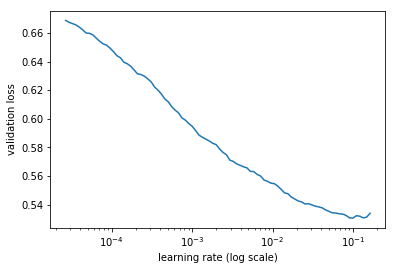

In [102]:
m.lr_find()
m.sched.plot(10)

In [103]:
# This is how the code looks in the 'metrics.py' in fastai library

def accuracy(preds, targs):
    preds = torch.max(preds, dim=1)[1]
    return (preds==targs).float().mean()

In [104]:
m.fit(lr, 3, metrics=[accuracy])

epoch      trn_loss   val_loss   accuracy                    
    0      0.484807   0.509149   0.767871  
    1      0.473337   0.513788   0.768926                    
    2      0.468036   0.511367   0.767344                    



[array([0.51137]), 0.7673437043030008]

In [105]:
m.fit(lr, 5, cycle_len=1, metrics=[accuracy])

epoch      trn_loss   val_loss   accuracy                    
    0      0.454067   0.51066    0.763651  
    1      0.446212   0.50761    0.764706                    
    2      0.441395   0.515754   0.758375                    
    3      0.431395   0.520214   0.751781                    
    4      0.423994   0.537442   0.732261                    



[array([0.53744]), 0.7322606137766746]

In [106]:
# m.fit(lr, 3, cycle_len=4, cycle_mult=2 , metrics=[accuracy])

In [107]:
m.save(modelName)

In [108]:
m.load(modelName)

## Validation

In [109]:
(x,yl)=m.predict_with_targs()

In [110]:
val = p.train.iloc[val_idx]
val[[dep]]
valpred = pd.DataFrame({
    'Close':val.Close,
    'index':val.index,
    'action':val.action,
    'predicted':np.argmax(x,axis=1)
})[['Close','index', 'action','predicted']]
valpred

,Close,index,action,predicted
Timestamp,,,,
2018-06-21 12:40:00,6732.270020,2018-06-21 12:40:00,0,0
2018-06-21 12:41:00,6736.899902,2018-06-21 12:41:00,0,0
2018-06-21 12:42:00,6735.279785,2018-06-21 12:42:00,0,0
2018-06-21 12:43:00,6734.990234,2018-06-21 12:43:00,0,0
2018-06-21 12:44:00,6736.729980,2018-06-21 12:44:00,0,0
2018-06-21 12:45:00,6735.509766,2018-06-21 12:45:00,0,0
2018-06-21 12:46:00,6735.509766,2018-06-21 12:46:00,0,0
2018-06-21 12:47:00,6735.500000,2018-06-21 12:47:00,0,0
2018-06-21 12:48:00,6735.509766,2018-06-21 12:48:00,0,0


Calculate the percent accuracy on the validation set

In [111]:
p.calculate_accuracy(valpred)


{'F1Score': 0.603,
 'totalAccuracy': 0.732,
 'buyAccuracy': 0.352,
 'sellAccuracy': 0.854,
 'totalBuyActions': 917,
 'successfulBuyPredictions': 323}

In [112]:
# from sklearn.metrics import classification_report
# print(classification_report(valpred.action,
#                             valpred.predicted,
#                             target_names= ['0', '1']))

In [113]:
p.calculate_net_profit(valpred, 15000, 0)
p.result

{'startClose': 6732.27,
 'endClose': 6111.77,
 'startAmount': 15000,
 'endAmount': 14961.191136061927,
 'buyAndHoldPercentIncrease': -9.217,
 'percentIncrease': -0.259,
 'percentDifference': 8.958,
 'totalTrades': 294}

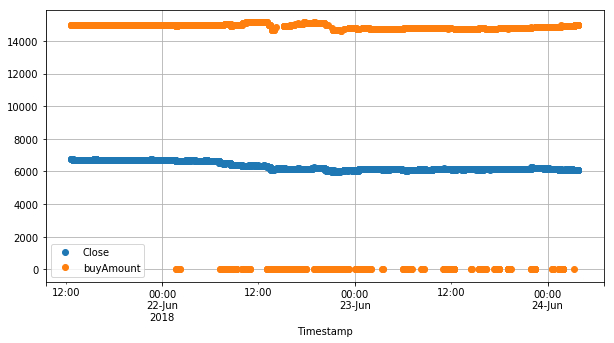

In [114]:
p.plot_profit(p.net_profit_df)

In [115]:
p.net_profit_df

,Timestamp,Close,index,action,predicted,buyAmount,sellAmount
0,2018-06-21 12:40:00,6732.270020,2018-06-21 12:40:00,0,0,15000.000000,0.000000
1,2018-06-21 12:41:00,6736.899902,2018-06-21 12:41:00,0,0,15000.000000,0.000000
2,2018-06-21 12:42:00,6735.279785,2018-06-21 12:42:00,0,0,15000.000000,0.000000
3,2018-06-21 12:43:00,6734.990234,2018-06-21 12:43:00,0,0,15000.000000,0.000000
4,2018-06-21 12:44:00,6736.729980,2018-06-21 12:44:00,0,0,15000.000000,0.000000
5,2018-06-21 12:45:00,6735.509766,2018-06-21 12:45:00,0,0,15000.000000,0.000000
6,2018-06-21 12:46:00,6735.509766,2018-06-21 12:46:00,0,0,15000.000000,0.000000
7,2018-06-21 12:47:00,6735.500000,2018-06-21 12:47:00,0,0,15000.000000,0.000000
8,2018-06-21 12:48:00,6735.509766,2018-06-21 12:48:00,0,0,15000.000000,0.000000
9,2018-06-21 12:49:00,6735.620117,2018-06-21 12:49:00,0,0,15000.000000,0.000000


## Test

In [116]:
np.argmax(m.predict(True), axis =1)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..., 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0])

In [117]:
testPred = pd.DataFrame({
    'index':p.test.index,
    'Close':p.test.Close,
    'action':p.test.action, 
    'predicted':np.argmax(m.predict(True), axis =1)
})[['index','Close','action', 'predicted']]
testPred.head(10)

,index,Close,action,predicted
Timestamp,,,,
2018-06-24 03:51:00,2018-06-24 03:51:00,6095.000000,0,0
2018-06-24 03:52:00,2018-06-24 03:52:00,6096.259766,0,0
2018-06-24 03:53:00,2018-06-24 03:53:00,6100.839844,0,0
2018-06-24 03:54:00,2018-06-24 03:54:00,6090.120117,0,0
2018-06-24 03:55:00,2018-06-24 03:55:00,6100.000000,0,0
2018-06-24 03:56:00,2018-06-24 03:56:00,6101.430176,0,0
2018-06-24 03:57:00,2018-06-24 03:57:00,6101.750000,0,0
2018-06-24 03:58:00,2018-06-24 03:58:00,6089.029785,0,0
2018-06-24 03:59:00,2018-06-24 03:59:00,6085.000000,0,0


In [118]:
p.calculate_accuracy(testPred)

{'F1Score': 0.595,
 'totalAccuracy': 0.716,
 'buyAccuracy': 0.315,
 'sellAccuracy': 0.874,
 'totalBuyActions': 1133,
 'successfulBuyPredictions': 357}

In [119]:
p.calculate_net_profit(testPred, 15000, 0)
p.result

{'startClose': 6095.0,
 'endClose': 6132.99,
 'startAmount': 15000,
 'endAmount': 15923.365120575712,
 'buyAndHoldPercentIncrease': 0.623,
 'percentIncrease': 6.156,
 'percentDifference': 5.532,
 'totalTrades': 236}

In [120]:
p.net_profit_df

,index,Close,action,predicted,buyAmount,sellAmount
Timestamp,,,,,,
2018-06-24 03:51:00,2018-06-24 03:51:00,6095.000000,0,0,15000.000000,0.000000
2018-06-24 03:52:00,2018-06-24 03:52:00,6096.259766,0,0,15000.000000,0.000000
2018-06-24 03:53:00,2018-06-24 03:53:00,6100.839844,0,0,15000.000000,0.000000
2018-06-24 03:54:00,2018-06-24 03:54:00,6090.120117,0,0,15000.000000,0.000000
2018-06-24 03:55:00,2018-06-24 03:55:00,6100.000000,0,0,15000.000000,0.000000
2018-06-24 03:56:00,2018-06-24 03:56:00,6101.430176,0,0,15000.000000,0.000000
2018-06-24 03:57:00,2018-06-24 03:57:00,6101.750000,0,0,15000.000000,0.000000
2018-06-24 03:58:00,2018-06-24 03:58:00,6089.029785,0,0,15000.000000,0.000000
2018-06-24 03:59:00,2018-06-24 03:59:00,6085.000000,0,0,15000.000000,0.000000


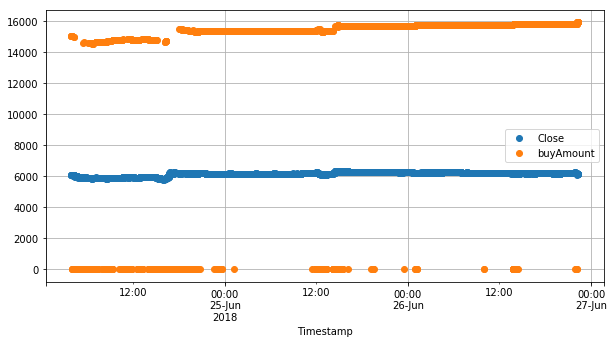

In [121]:
p.plot_profit(p.net_profit_df)

             precision    recall  f1-score   support

          0       0.76      0.87      0.81      2857
          1       0.50      0.32      0.39      1133

avg / total       0.69      0.72      0.69      3990

Confusion matrix, without normalization
[[2498  359]
 [ 776  357]]


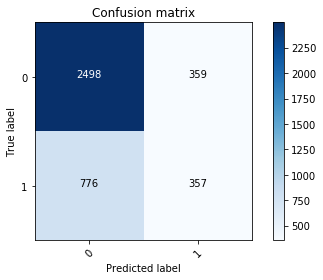

In [122]:
p.confusion_matrix(testPred.action,testPred.predicted, ['0', '1'], [0, 1])

## Single Prediction


In [123]:
df_row = df_test.tail(10) # last row
prediciton = m.predict_array(df_row[cat_vars], df_row[contin_vars])
# prediciton, np.argmax(prediciton, axis=1)

## Random Forrest


In [133]:
from sklearn.ensemble import RandomForestRegressor
mrf = RandomForestRegressor(n_estimators=40, max_features=0.99, min_samples_leaf=2,
                          n_jobs=-1, oob_score=True)
mrf.fit(df.values, y);

In [140]:
mrf.score(df_test.values,p.test[dep])

-0.11467397360058751

In [142]:
preds = mrf.predict(df_test.values)

             precision    recall  f1-score   support

          0       0.78      0.47      0.59      2857
          1       0.33      0.67      0.45      1133

avg / total       0.66      0.53      0.55      3990

Confusion matrix, without normalization
[[1349 1508]
 [ 374  759]]


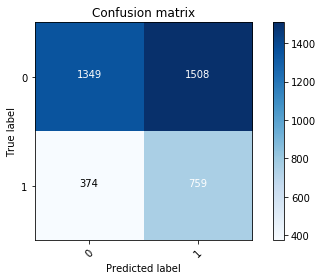

In [135]:
p.confusion_matrix(p.test[dep], PredtoClass(preds), ['0', '1'], [0, 1])

In [143]:
testPred.predicted = PredtoClass(preds)
p.calculate_accuracy(testPred)

{'F1Score': 0.571,
 'totalAccuracy': 0.528,
 'buyAccuracy': 0.67,
 'sellAccuracy': 0.472,
 'totalBuyActions': 1133,
 'successfulBuyPredictions': 759}

In [145]:
p.calculate_net_profit(testPred, 15000, 0)
p.result

{'startClose': 6095.0,
 'endClose': 6132.99,
 'startAmount': 15000,
 'endAmount': 15545.169895635467,
 'buyAndHoldPercentIncrease': 0.623,
 'percentIncrease': 3.634,
 'percentDifference': 3.011,
 'totalTrades': 625}

## AdaBoost


In [136]:
from sklearn.ensemble import AdaBoostClassifier
ada = AdaBoostClassifier(random_state=1)
ada.fit(df.values, y)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=1)

In [137]:
ada.score(df_test.values,p.test[dep])

0.7105263157894737

In [148]:
preds = ada.predict(df_test.values)

             precision    recall  f1-score   support

          0       0.78      0.47      0.59      2857
          1       0.33      0.67      0.45      1133

avg / total       0.66      0.53      0.55      3990

Confusion matrix, without normalization
[[1349 1508]
 [ 374  759]]


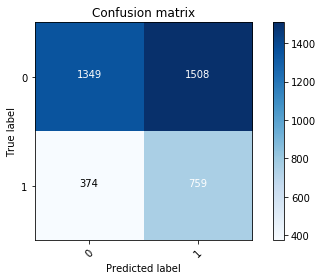

In [146]:
p.confusion_matrix(p.test[dep], PredtoClass(preds), ['0', '1'], [0, 1])

In [149]:
testPred.predicted = PredtoClass(preds)
p.calculate_accuracy(testPred)

{'F1Score': 0.607,
 'totalAccuracy': 0.711,
 'buyAccuracy': 0.369,
 'sellAccuracy': 0.846,
 'totalBuyActions': 1133,
 'successfulBuyPredictions': 418}

In [150]:
p.calculate_net_profit(testPred, 15000, 0)
p.result

{'startClose': 6095.0,
 'endClose': 6132.99,
 'startAmount': 15000,
 'endAmount': 15488.397260070453,
 'buyAndHoldPercentIncrease': 0.623,
 'percentIncrease': 3.256,
 'percentDifference': 2.633,
 'totalTrades': 102}

## Ensemble


In [158]:
from sklearn.ensemble import VotingClassifier
#create a dictionary of our models
# , ('rnn', m)
estimators=[('ada', ada), ('rf', mrf)]
#create our voting classifier, inputting our models
ensemble = VotingClassifier(estimators, voting='hard')

In [ ]:
#fit model to training data
ensemble.fit(df.values, y)
#test our model on the test data
ensemble.score(df_test.values,p.test[dep])

In [ ]:
preds = ada.predict(df_test.values)
p.confusion_matrix(p.test[dep], PredtoClass(preds), ['0', '1'], [0, 1])
testPred.predicted = PredtoClass(preds)
p.calculate_accuracy(testPred)
p.calculate_net_profit(testPred, 15000, 0)
p.result